# LIT-PCBA 
this dataset is a proposed "more difficult" test than DUD-E. I used a 75/25 (sklearn default) stratified split. The dataset is heavily imbalanced, like DUD-E.

In [1]:
import pickle
from sklearn.metrics import roc_auc_score
import numpy as np
import seaborn as sns
import torch
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from pathlib import Path
from sklearn.metrics import f1_score, recall_score
import matplotlib.pyplot as plt
import sys
# sys.path.append('..')
sys.path.insert(0, "/g/g13/jones289/workspace/hd-cuda-master")
# print(sys.path)
import hdpy
import hdpy.ecfp
# from hdpy.analysis import load_pkl
from hdpy.metrics import compute_enrichment_factor
from pathlib import Path


plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=17)
plt.rc('figure', titlesize=20)


# SEED=125
SEED=5
# SEED=2

data_p = Path(f"/p/vast1/jones289/hd_results/{SEED}")

In [2]:
green_color_pal = sns.color_palette("Greens", 10)
blue_color_pal = sns.color_palette("Blues", 10)
rocket_color_pal = sns.color_palette("rocket", 10)

In [3]:
model_dict = {
    "molehd-bpe": ("MoleHD-BPE", rocket_color_pal[4]),
    "hdbind-rp-molformer": ("HDBind+MolFormer", green_color_pal[4]),
    "hdbind-ecfp-1024-1-100": ("HDBind+ECFP-100", green_color_pal[6]),
    "hdbind-ecfp-1024-1-1k": ("HDBind+ECFP-1k", green_color_pal[6]),
    "hdbind-rp-ecfp-1024-1": ("HDBind+ECFP-10k", green_color_pal[6]),
    "hdbind-ecfp-1024-1-100k": ("HDBind+ECFP-100k", green_color_pal[9]),
    "mlp-1024-1": ("MLP", blue_color_pal[7]),
    "Vina": ("Vina", "salmon"),
}

# LIT-PCBA Results

export CONDA_ROOT=/usr/workspace/jones289/anaconda3-power #installed using the LC installer script
export PATH=$CONDA_ROOT/bin:$PATH
export CONDA_EXE=$CONDA_ROOT/bin/conda
ml load gcc/11
export PYTHONPATH=$PWD:$PYTHONPATH
source activate /usr/workspace/jones289/anaconda3-power/envs/opence-1.8.0

In [4]:
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score


def compute_metrics(y_pred, y_score, y_true, p):
#     import pdb
#     pdb.set_trace()


    if y_score.squeeze().ndim == 2:
        enrich = float(compute_enrichment_factor(scores=y_score[:, 1], labels=y_true, n_percent=p))
        roc = roc_auc_score(y_score=y_score[:, 1], y_true=y_true)
    else:
        enrich = float(compute_enrichment_factor(scores=y_score, labels=y_true, n_percent=p))
        roc = roc_auc_score(y_score=y_score, y_true=y_true)

    
    
    return {"precision": precision_score(y_pred=y_pred, y_true=y_true, zero_division=0),
            "recall": recall_score(y_pred=y_pred, y_true=y_true),
           "f1": f1_score(y_pred=y_pred, y_true=y_true, zero_division=0),
            "enrich": enrich,            
           "roc": roc
           }


def aggregate_results(dataset, range_limit=10, multistep_initial_p=None, 
                      multistep_p_list=None, 
                      multistep_sklearn_model=None):
    
    model_metric_dict = {"model": [], "enrich": [], "p":[], "train_time":[], "test_time": [], "target": [],
                        "seed": [], "recall": [], "precision": [], "f1": [], 
                        }

    for model_name, model_tup in tqdm(model_dict.items(), total=len(model_dict), position=0):
                        

        data_path_list = list(data_p.glob(f"{model_name}.{dataset}*.pkl"))
        print(f"{model_name}-{dataset}: {len(model_tup)}\t {len(data_path_list)}")

        

        for path in tqdm(data_path_list, total=len(data_path_list), position=1):

            
#             model_data_dict = pd.read_pickle(path)
            model_data_dict = torch.load(path)
            target = path.name.split(".")[1]
            
            print(target, path, model_name)

            for seed in range(len(model_data_dict['trials'])):
                trial_dict = model_data_dict['trials'][seed]

                y_test = model_data_dict["y_test"]
                actives_database = sum(y_test)
                database_size = y_test.shape[0]



                hdc_conf_scores = trial_dict["eta"]
                for p in [.01, .1]:

                    try:

                        metrics = compute_metrics(y_pred=trial_dict["y_pred"], 
                                                  y_score=hdc_conf_scores, 
                                                  y_true=model_data_dict["y_test"],
                                                 p=p)

                        model_metric_dict["target"].append(target)
                        model_metric_dict["test_time"].append(trial_dict["test_time"])
                        model_metric_dict["enrich"].append(metrics["enrich"])
                        model_metric_dict["p"].append(p)
                        model_metric_dict["seed"].append(seed)
                        model_metric_dict["precision"].append(metrics["precision"])
                        model_metric_dict["recall"].append(metrics["recall"])
                        model_metric_dict["f1"].append(metrics["f1"])
                        model_metric_dict["model"].append(model_name)
                    except Exception as e:
                        print(e)


    model_metric_df = pd.DataFrame({key: value for key, value in model_metric_dict.items() if key not in ["train_time", "test_time", "precision", "recall", "f1"]})
    return model_metric_df
        


# VINA result

In [5]:
from pathlib import Path

def load_lit_pcba_vina(nrows=None):
    root_p = Path("/p/lustre2/ahashare/zhang30/LIT-PCBA-Data/")

    path_list = [path for path in root_p.glob("*-actives.csv")]


    df_list = []

    for idx, path in tqdm(enumerate(path_list), total=len(path_list)):
        print(idx, path)
        
#         '''
        target = path.name.split(".")[0].split("-")[0]
        print(target, idx+1, path)
        
        

        merged_df = None
        merged_df_path = Path(f"./lit_pcba_docking_analysis/{target}.csv")
        
        if not merged_df_path.exists():
            # can use the set of smiles in each result file
            
            # todo (10/18/23): is this valid?
            result_pkl = Path(f"/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/124/lit_pcba.{target}.ecfp.atomwise.0.pkl")        


            target_train_smiles_list = []
            target_test_smiles_list = []

            with open(result_pkl, "rb") as handle:

                data = pickle.load(handle)

                target_train_smiles_list = data["smiles_train"]
                target_test_smiles_list = data["smiles_test"]

                print(f"total of {len(target_train_smiles_list)} in training set, total of {len(target_test_smiles_list)} in testing set.")

            df_cols = ['file', ' scores/1', ' ligName']
            active_df = pd.read_csv(root_p / Path(f"{target}-actives.csv.clean"), sep=",", usecols=df_cols, nrows=nrows)
            active_df['y_true'] = [1] * len(active_df)



            inactive_df = pd.read_csv(root_p / Path(f"{target}-inactives.csv.clean"), sep=",", usecols=df_cols, nrows=nrows)
            inactive_df['y_true'] = [0] * len(inactive_df)

            target_df = pd.concat([active_df, inactive_df])
            # this will search over all of the docking results for each target, across each of the multiple protein models

            active_smiles_df = pd.read_csv(f"/p/vast1/jones289/lit_pcba/{target}/actives.smi", delim_whitespace=True, header=None)
            inactive_smiles_df = pd.read_csv(f"/p/vast1/jones289/lit_pcba/{target}/inactives.smi", delim_whitespace=True, header=None)
            target_smiles_df = pd.concat([active_smiles_df, inactive_smiles_df])



            top_pose_target_df = target_df.groupby([' ligName'], as_index=False)[[' ligName', ' scores/1', 'y_true']].min()


        
            merged_df_path.parent.mkdir(exist_ok=True, parents=True)
            merged_df = pd.merge(top_pose_target_df, target_smiles_df, left_on=" ligName", right_on=1)
            merged_df = merged_df[merged_df.apply(lambda x: x[0] in target_test_smiles_list, axis=1)]
            merged_df['target'] = [target] * len(merged_df)
            merged_df.to_csv(merged_df_path, index=False)
        else:
            merged_df = pd.read_csv(merged_df_path)
            
            if 'target' not in merged_df.columns:
                merged_df['target'] = [target] * len(merged_df)
                merged_df.to_csv(merged_df_path, index=False)



        df_list.append(merged_df)

    df = pd.concat(df_list)
    return df

In [6]:
lit_pcba_vina_df = load_lit_pcba_vina()
lit_pcba_vina_df

  7%|▋         | 1/15 [00:00<00:02,  5.00it/s]

0 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/PKM2-actives.csv
PKM2 1 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/PKM2-actives.csv
1 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/GBA-actives.csv
GBA 2 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/GBA-actives.csv


 13%|█▎        | 2/15 [00:00<00:02,  4.94it/s]

2 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/ESR1_ago-actives.csv
ESR1_ago 3 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/ESR1_ago-actives.csv
3 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/MAPK1-actives.csv
MAPK1 4 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/MAPK1-actives.csv
4 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/VDR-actives.csv
VDR 5 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/VDR-actives.csv


 33%|███▎      | 5/15 [00:00<00:01,  8.23it/s]

5 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/KAT2A-actives.csv
KAT2A 6 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/KAT2A-actives.csv


 53%|█████▎    | 8/15 [00:00<00:00,  9.55it/s]

6 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/ALDH1-actives.csv
ALDH1 7 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/ALDH1-actives.csv
7 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/TP53-actives.csv
TP53 8 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/TP53-actives.csv
8 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/PPARG-actives.csv
PPARG 9 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/PPARG-actives.csv
9 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/ADRB2-actives.csv
ADRB2 10 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/ADRB2-actives.csv


 80%|████████  | 12/15 [00:01<00:00, 10.93it/s]

10 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/MTORC1-actives.csv
MTORC1 11 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/MTORC1-actives.csv
11 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/OPRK1-actives.csv
OPRK1 12 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/OPRK1-actives.csv
12 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/IDH1-actives.csv
IDH1 13 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/IDH1-actives.csv


100%|██████████| 15/15 [00:01<00:00,  8.85it/s]

13 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/ESR1_ant-actives.csv
ESR1_ant 14 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/ESR1_ant-actives.csv
14 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/FEN1-actives.csv
FEN1 15 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/FEN1-actives.csv


,ligName,scores/1,y_true,0,1,target
0,842131,-10.9,0,C(Nc1nc(nc2ccccc12)N3CCCCC3)c4occc4,842131,PKM2
1,842137,-13.6,0,Cc1ccc2nc(N3CC[NH+](Cc4nnnn4Cc5ccccc5)CC3)c(cc...,842137,PKM2
2,842144,-11.0,0,Cc1ccc(C)c(NC(=O)CSc2nnc(CSc3nc(C)cc(C)n3)n2Cc...,842144,PKM2
3,842162,-11.3,0,COc1cccc(c1)C(=O)Nc2ccc(cc2)S(=O)(=O)NCc3occc3,842162,PKM2
4,842164,-8.8,0,O=C(Cn1nnc(n1)c2cccs2)OC3CCCCC3,842164,PKM2
...,...,...,...,...,...,...
90550,124899201,-5.2,0,[O-][N+](=O)c1cccc(\C=C\c2ccccc2)c1,124899201,FEN1
90551,124899232,-5.1,0,CN(CCCCCC[NH3+])c1nccc(n1)N2CC[NH+](C)CC2,124899232,FEN1
90552,124899250,-5.3,0,ONC(=O)Cc1ccc(OCC2CCCCC2)cc1,124899250,FEN1
90553,124899255,-4.9,0,CC(C)CCOc1ccc(CC(=O)NO)cc1,124899255,FEN1


In [7]:
def load_dude_vina(nrows=None):
    vina_root_p = Path("/p/lustre1/jones289/DUDE-38/")
    vina_path_list = [path for path in vina_root_p.glob("*-active-summary.txt")]

    df_list = []


    # root_dude_dir = Path("/g/g13/jones289/workspace/hd-cuda-master/datasets/dude/dude_smiles/")
    root_dude_dir = Path("/g/g13/jones289/workspace/hd-cuda-master/datasets/dude_smiles")
    for idx, path in enumerate(tqdm(vina_path_list)):
    #     print(idx, path)
        target = path.name.split(".")[0].split("-")[0]
#         print(target, idx+1, path)

        # for some reason don't have inactive data for abl1
        if target in ["abl1", "fgfr1"]:
            tqdm.write(f"{target} not found. skipping.")
            continue

#         if target in dude_target_names:
        else:

            active_df = pd.read_csv(f"/p/lustre1/jones289/DUDE-38/{target}-active-summary.txt", header=None, delim_whitespace=True)
            active_df['y_true'] = [1] * len(active_df)

            decoy_df = pd.read_csv(f"/p/lustre1/jones289/DUDE-38/{target}-decoy-summary.txt", header=None, delim_whitespace=True)
            decoy_df['y_true'] = [0] * len(decoy_df)


            target_df = pd.concat([active_df, decoy_df])

            target_df["target"] = [target] * len(target_df)

            target_df["vina"] = target_df[2]
            target_df["gbsa"] = target_df[3]

            target_df["cmpd_id"] = target_df[1]

            target_df["target_size"] = target_df.shape[0]

    #         import pdb
    #         pdb.set_trace()
            random_split_df = pd.read_csv(root_dude_dir/ Path(f"{target}_gbsa_smiles_with_base_rdkit_smiles_train_valid_test_random_random.csv"))


    #         import pdb
    #         pdb.set_trace()

            # we only use the scores from the test set to attempt an even comparison

            merged_df = pd.merge(target_df, random_split_df, on="cmpd_id")
            merged_df = merged_df.loc[merged_df['subset'] == "test"]

#             print(merged_df.shape)

            df_list.append(merged_df)
#         else:
#             pass

    df = pd.concat(df_list)

    return df
    

In [8]:
dude_vina_df = load_dude_vina()
dude_vina_df

 32%|███▎      | 13/40 [00:02<00:03,  7.38it/s]

fgfr1 not found. skipping.


 38%|███▊      | 15/40 [00:02<00:04,  5.93it/s]

abl1 not found. skipping.


100%|██████████| 40/40 [00:05<00:00,  6.70it/s]


,0,1,2,3,y_true,target,vina,gbsa,cmpd_id,target_size,subset
65,158,CHEMBL178355,-7.3,-23.4889,1,pgh1,-7.3,-23.4889,CHEMBL178355,9475,test
68,161,CHEMBL283267,-7.7,-26.2514,1,pgh1,-7.7,-26.2514,CHEMBL283267,9475,test
69,162,CHEMBL184374,-7.1,-22.7434,1,pgh1,-7.1,-22.7434,CHEMBL184374,9475,test
79,171,CHEMBL433892,-7.3,-29.1098,1,pgh1,-7.3,-29.1098,CHEMBL433892,9475,test
90,180,CHEMBL404928,-6.6,-22.1502,1,pgh1,-6.6,-22.1502,CHEMBL404928,9475,test
...,...,...,...,...,...,...,...,...,...,...,...
8660,994,ZINC35141443,-7.8,-28.5967,0,gcr,-7.8,-28.5967,ZINC35141443,11247,test
8661,9941,ZINC08387402,-7.3,-5.9566,0,gcr,-7.3,-5.9566,ZINC08387402,11247,test
8678,9969,ZINC64795840,-7.4,-20.0953,0,gcr,-7.4,-20.0953,ZINC64795840,11247,test
8698,9992,ZINC02647100,-5.5,-11.0534,0,gcr,-5.5,-11.0534,ZINC02647100,11247,test


In [9]:
def compute_model_metric_df(dataset):
    
    model_metric_df = aggregate_results(dataset=dataset,multistep_p_list=[.05, .5],  
                                          multistep_sklearn_model="rf", 
                                         multistep_initial_p=.2)


    # model_metric_df

    #######
    if dataset == "lit-pcba":
        docking_df = load_lit_pcba_vina()
    elif dataset == "dude":
        docking_df = load_dude_vina()

    ###########
    
    docking_dict = {"enrich": [], "p": [], "model": [], "target": []}

    vina_enrich_list = []
    target_list = []
    vina_col='vina'
    for target, target_df in docking_df.groupby("target"):

        for p in [.1, .01]:
            enrich = compute_enrichment_factor(scores=np.abs(target_df[vina_col]), 
                                      labels=target_df["y_true"], 
                                      n_percent=p)

            docking_dict["enrich"].append(float(enrich))
            docking_dict["p"].append(p)
            docking_dict["model"].append("Vina")
            docking_dict["target"].append(target)
            
#     import pdb
#     pdb.set_trace()
    
    
    
    ##################
    model_metric_df = pd.concat([model_metric_df, pd.DataFrame(docking_dict)])
    
    # Backup the calculation
#     model_metric_df.to_csv("fixed_litpcba_model_metric_df.csv")
    
#     import pdb
#     pdb.set_trace()
    return model_metric_df    


In [10]:
model_metric_df = compute_model_metric_df(dataset="dude")

  0%|          | 0/8 [00:00<?, ?it/s]

molehd-bpe-dude: 2	 38



  0%|          | 0/38 [00:00<?, ?it/s]

dude-ace /p/vast1/jones289/hd_results/5/molehd-bpe.dude-ace.5.pkl molehd-bpe



  3%|▎         | 1/38 [00:00<00:23,  1.57it/s]

dude-aces /p/vast1/jones289/hd_results/5/molehd-bpe.dude-aces.5.pkl molehd-bpe



  5%|▌         | 2/38 [00:01<00:24,  1.49it/s]

dude-ada /p/vast1/jones289/hd_results/5/molehd-bpe.dude-ada.5.pkl molehd-bpe



  8%|▊         | 3/38 [00:01<00:16,  2.10it/s]

dude-aldr /p/vast1/jones289/hd_results/5/molehd-bpe.dude-aldr.5.pkl molehd-bpe



 13%|█▎        | 5/38 [00:02<00:11,  2.79it/s]

dude-ampc /p/vast1/jones289/hd_results/5/molehd-bpe.dude-ampc.5.pkl molehd-bpe
dude-andr /p/vast1/jones289/hd_results/5/molehd-bpe.dude-andr.5.pkl molehd-bpe



 16%|█▌        | 6/38 [00:02<00:10,  3.00it/s]

dude-bace1 /p/vast1/jones289/hd_results/5/molehd-bpe.dude-bace1.5.pkl molehd-bpe



 18%|█▊        | 7/38 [00:03<00:12,  2.52it/s]

dude-cdk2 /p/vast1/jones289/hd_results/5/molehd-bpe.dude-cdk2.5.pkl molehd-bpe



 24%|██▎       | 9/38 [00:04<00:13,  2.22it/s]

dude-comt /p/vast1/jones289/hd_results/5/molehd-bpe.dude-comt.5.pkl molehd-bpe
dude-dyr /p/vast1/jones289/hd_results/5/molehd-bpe.dude-dyr.5.pkl molehd-bpe



 26%|██▋       | 10/38 [00:04<00:13,  2.01it/s]

dude-egfr /p/vast1/jones289/hd_results/5/molehd-bpe.dude-egfr.5.pkl molehd-bpe



 29%|██▉       | 11/38 [00:05<00:18,  1.46it/s]

dude-esr1 /p/vast1/jones289/hd_results/5/molehd-bpe.dude-esr1.5.pkl molehd-bpe



 32%|███▏      | 12/38 [00:06<00:16,  1.56it/s]

dude-fa10 /p/vast1/jones289/hd_results/5/molehd-bpe.dude-fa10.5.pkl molehd-bpe



 34%|███▍      | 13/38 [00:07<00:16,  1.55it/s]

dude-gcr /p/vast1/jones289/hd_results/5/molehd-bpe.dude-gcr.5.pkl molehd-bpe



 37%|███▋      | 14/38 [00:07<00:13,  1.82it/s]

dude-hivpr /p/vast1/jones289/hd_results/5/molehd-bpe.dude-hivpr.5.pkl molehd-bpe



 42%|████▏     | 16/38 [00:08<00:11,  1.87it/s]

dude-hivrt /p/vast1/jones289/hd_results/5/molehd-bpe.dude-hivrt.5.pkl molehd-bpe
dude-hmdh /p/vast1/jones289/hd_results/5/molehd-bpe.dude-hmdh.5.pkl molehd-bpe



 45%|████▍     | 17/38 [00:08<00:09,  2.15it/s]

dude-hs90a /p/vast1/jones289/hd_results/5/molehd-bpe.dude-hs90a.5.pkl molehd-bpe



 50%|█████     | 19/38 [00:09<00:06,  3.11it/s]

dude-inha /p/vast1/jones289/hd_results/5/molehd-bpe.dude-inha.5.pkl molehd-bpe
dude-kith /p/vast1/jones289/hd_results/5/molehd-bpe.dude-kith.5.pkl molehd-bpe



 55%|█████▌    | 21/38 [00:09<00:03,  4.27it/s]

dude-mcr /p/vast1/jones289/hd_results/5/molehd-bpe.dude-mcr.5.pkl molehd-bpe
dude-mk14 /p/vast1/jones289/hd_results/5/molehd-bpe.dude-mk14.5.pkl molehd-bpe



 58%|█████▊    | 22/38 [00:10<00:08,  1.95it/s]

dude-nram /p/vast1/jones289/hd_results/5/molehd-bpe.dude-nram.5.pkl molehd-bpe



 61%|██████    | 23/38 [00:10<00:06,  2.30it/s]

dude-parp1 /p/vast1/jones289/hd_results/5/molehd-bpe.dude-parp1.5.pkl molehd-bpe



 63%|██████▎   | 24/38 [00:11<00:08,  1.69it/s]

dude-pde5a /p/vast1/jones289/hd_results/5/molehd-bpe.dude-pde5a.5.pkl molehd-bpe



 66%|██████▌   | 25/38 [00:12<00:08,  1.53it/s]

dude-pgh1 /p/vast1/jones289/hd_results/5/molehd-bpe.dude-pgh1.5.pkl molehd-bpe



 68%|██████▊   | 26/38 [00:13<00:06,  1.78it/s]

dude-pgh2 /p/vast1/jones289/hd_results/5/molehd-bpe.dude-pgh2.5.pkl molehd-bpe



 71%|███████   | 27/38 [00:13<00:06,  1.76it/s]

dude-pnph /p/vast1/jones289/hd_results/5/molehd-bpe.dude-pnph.5.pkl molehd-bpe



 74%|███████▎  | 28/38 [00:13<00:04,  2.10it/s]

dude-pparg /p/vast1/jones289/hd_results/5/molehd-bpe.dude-pparg.5.pkl molehd-bpe



 76%|███████▋  | 29/38 [00:14<00:05,  1.72it/s]

dude-prgr /p/vast1/jones289/hd_results/5/molehd-bpe.dude-prgr.5.pkl molehd-bpe



 82%|████████▏ | 31/38 [00:15<00:02,  2.45it/s]

dude-pur2 /p/vast1/jones289/hd_results/5/molehd-bpe.dude-pur2.5.pkl molehd-bpe
dude-pygm /p/vast1/jones289/hd_results/5/molehd-bpe.dude-pygm.5.pkl molehd-bpe



 84%|████████▍ | 32/38 [00:15<00:02,  2.91it/s]

dude-rxra /p/vast1/jones289/hd_results/5/molehd-bpe.dude-rxra.5.pkl molehd-bpe



 89%|████████▉ | 34/38 [00:15<00:01,  3.62it/s]

dude-sahh /p/vast1/jones289/hd_results/5/molehd-bpe.dude-sahh.5.pkl molehd-bpe
dude-src /p/vast1/jones289/hd_results/5/molehd-bpe.dude-src.5.pkl molehd-bpe



 92%|█████████▏| 35/38 [00:16<00:01,  1.95it/s]

dude-thrb /p/vast1/jones289/hd_results/5/molehd-bpe.dude-thrb.5.pkl molehd-bpe



 95%|█████████▍| 36/38 [00:17<00:00,  2.19it/s]

dude-try1 /p/vast1/jones289/hd_results/5/molehd-bpe.dude-try1.5.pkl molehd-bpe



 97%|█████████▋| 37/38 [00:17<00:00,  2.44it/s]

dude-vgfr2 /p/vast1/jones289/hd_results/5/molehd-bpe.dude-vgfr2.5.pkl molehd-bpe



 12%|█▎        | 1/8 [00:18<02:07, 18.20s/it]

hdbind-rp-molformer-dude: 2	 38



  0%|          | 0/38 [00:00<?, ?it/s]

dude-ace /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.dude-ace.5.pkl hdbind-rp-molformer



  3%|▎         | 1/38 [00:00<00:13,  2.76it/s]

dude-aces /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.dude-aces.5.pkl hdbind-rp-molformer



  8%|▊         | 3/38 [00:01<00:11,  3.16it/s]

dude-ada /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.dude-ada.5.pkl hdbind-rp-molformer
dude-aldr /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.dude-aldr.5.pkl hdbind-rp-molformer



 13%|█▎        | 5/38 [00:01<00:07,  4.29it/s]

dude-ampc /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.dude-ampc.5.pkl hdbind-rp-molformer
dude-andr /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.dude-andr.5.pkl hdbind-rp-molformer



 16%|█▌        | 6/38 [00:01<00:07,  4.51it/s]

dude-bace1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.dude-bace1.5.pkl hdbind-rp-molformer



 18%|█▊        | 7/38 [00:01<00:08,  3.79it/s]

dude-cdk2 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.dude-cdk2.5.pkl hdbind-rp-molformer



 24%|██▎       | 9/38 [00:02<00:08,  3.35it/s]

dude-comt /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.dude-comt.5.pkl hdbind-rp-molformer
dude-dyr /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.dude-dyr.5.pkl hdbind-rp-molformer



 26%|██▋       | 10/38 [00:03<00:08,  3.22it/s]

dude-egfr /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.dude-egfr.5.pkl hdbind-rp-molformer



 29%|██▉       | 11/38 [00:03<00:11,  2.36it/s]

dude-esr1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.dude-esr1.5.pkl hdbind-rp-molformer



 32%|███▏      | 12/38 [00:04<00:10,  2.46it/s]

dude-fa10 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.dude-fa10.5.pkl hdbind-rp-molformer



 34%|███▍      | 13/38 [00:04<00:09,  2.53it/s]

dude-gcr /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.dude-gcr.5.pkl hdbind-rp-molformer



 37%|███▋      | 14/38 [00:04<00:08,  2.89it/s]

dude-hivpr /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.dude-hivpr.5.pkl hdbind-rp-molformer



 42%|████▏     | 16/38 [00:05<00:07,  2.98it/s]

dude-hivrt /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.dude-hivrt.5.pkl hdbind-rp-molformer
dude-hmdh /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.dude-hmdh.5.pkl hdbind-rp-molformer



 47%|████▋     | 18/38 [00:05<00:05,  3.88it/s]

dude-hs90a /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.dude-hs90a.5.pkl hdbind-rp-molformer
dude-inha /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.dude-inha.5.pkl hdbind-rp-molformer



 53%|█████▎    | 20/38 [00:06<00:03,  5.14it/s]

dude-kith /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.dude-kith.5.pkl hdbind-rp-molformer
dude-mcr /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.dude-mcr.5.pkl hdbind-rp-molformer



 55%|█████▌    | 21/38 [00:06<00:02,  5.86it/s]

dude-mk14 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.dude-mk14.5.pkl hdbind-rp-molformer



 61%|██████    | 23/38 [00:07<00:04,  3.59it/s]

dude-nram /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.dude-nram.5.pkl hdbind-rp-molformer
dude-parp1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.dude-parp1.5.pkl hdbind-rp-molformer



 63%|██████▎   | 24/38 [00:07<00:05,  2.61it/s]

dude-pde5a /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.dude-pde5a.5.pkl hdbind-rp-molformer



 66%|██████▌   | 25/38 [00:08<00:05,  2.36it/s]

dude-pgh1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.dude-pgh1.5.pkl hdbind-rp-molformer



 68%|██████▊   | 26/38 [00:08<00:04,  2.63it/s]

dude-pgh2 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.dude-pgh2.5.pkl hdbind-rp-molformer



 74%|███████▎  | 28/38 [00:09<00:03,  2.91it/s]

dude-pnph /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.dude-pnph.5.pkl hdbind-rp-molformer
dude-pparg /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.dude-pparg.5.pkl hdbind-rp-molformer



 76%|███████▋  | 29/38 [00:09<00:03,  2.50it/s]

dude-prgr /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.dude-prgr.5.pkl hdbind-rp-molformer



 82%|████████▏ | 31/38 [00:10<00:02,  3.37it/s]

dude-pur2 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.dude-pur2.5.pkl hdbind-rp-molformer
dude-pygm /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.dude-pygm.5.pkl hdbind-rp-molformer



 87%|████████▋ | 33/38 [00:10<00:01,  4.16it/s]

dude-rxra /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.dude-rxra.5.pkl hdbind-rp-molformer
dude-sahh /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.dude-sahh.5.pkl hdbind-rp-molformer



 89%|████████▉ | 34/38 [00:10<00:00,  4.64it/s]

dude-src /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.dude-src.5.pkl hdbind-rp-molformer



 92%|█████████▏| 35/38 [00:11<00:01,  2.82it/s]

dude-thrb /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.dude-thrb.5.pkl hdbind-rp-molformer



 95%|█████████▍| 36/38 [00:11<00:00,  3.09it/s]

dude-try1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.dude-try1.5.pkl hdbind-rp-molformer



 97%|█████████▋| 37/38 [00:11<00:00,  3.38it/s]

dude-vgfr2 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.dude-vgfr2.5.pkl hdbind-rp-molformer



 25%|██▌       | 2/8 [00:30<01:28, 14.67s/it]

hdbind-ecfp-1024-1-100-dude: 2	 38



  0%|          | 0/38 [00:00<?, ?it/s]

dude-ace /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100.dude-ace.5.pkl hdbind-ecfp-1024-1-100



  3%|▎         | 1/38 [00:00<00:24,  1.48it/s]

dude-aces /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100.dude-aces.5.pkl hdbind-ecfp-1024-1-100



  5%|▌         | 2/38 [00:01<00:25,  1.40it/s]

dude-ada /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100.dude-ada.5.pkl hdbind-ecfp-1024-1-100



  8%|▊         | 3/38 [00:01<00:17,  2.00it/s]

dude-aldr /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100.dude-aldr.5.pkl hdbind-ecfp-1024-1-100



 13%|█▎        | 5/38 [00:02<00:11,  2.92it/s]

dude-ampc /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100.dude-ampc.5.pkl hdbind-ecfp-1024-1-100
dude-andr /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100.dude-andr.5.pkl hdbind-ecfp-1024-1-100



 16%|█▌        | 6/38 [00:02<00:10,  3.11it/s]

dude-bace1 /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100.dude-bace1.5.pkl hdbind-ecfp-1024-1-100



 18%|█▊        | 7/38 [00:03<00:13,  2.24it/s]

dude-cdk2 /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100.dude-cdk2.5.pkl hdbind-ecfp-1024-1-100



 21%|██        | 8/38 [00:04<00:19,  1.55it/s]

dude-comt /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100.dude-comt.5.pkl hdbind-ecfp-1024-1-100



 24%|██▎       | 9/38 [00:04<00:14,  1.97it/s]

dude-dyr /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100.dude-dyr.5.pkl hdbind-ecfp-1024-1-100



 26%|██▋       | 10/38 [00:04<00:14,  1.96it/s]

dude-egfr /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100.dude-egfr.5.pkl hdbind-ecfp-1024-1-100



 29%|██▉       | 11/38 [00:06<00:20,  1.29it/s]

dude-esr1 /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100.dude-esr1.5.pkl hdbind-ecfp-1024-1-100



 32%|███▏      | 12/38 [00:07<00:19,  1.33it/s]

dude-fa10 /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100.dude-fa10.5.pkl hdbind-ecfp-1024-1-100



 34%|███▍      | 13/38 [00:07<00:17,  1.42it/s]

dude-gcr /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100.dude-gcr.5.pkl hdbind-ecfp-1024-1-100



 37%|███▋      | 14/38 [00:07<00:14,  1.68it/s]

dude-hivpr /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100.dude-hivpr.5.pkl hdbind-ecfp-1024-1-100



 42%|████▏     | 16/38 [00:09<00:12,  1.71it/s]

dude-hivrt /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100.dude-hivrt.5.pkl hdbind-ecfp-1024-1-100
dude-hmdh /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100.dude-hmdh.5.pkl hdbind-ecfp-1024-1-100



 45%|████▍     | 17/38 [00:09<00:10,  1.98it/s]

dude-hs90a /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100.dude-hs90a.5.pkl hdbind-ecfp-1024-1-100



 50%|█████     | 19/38 [00:10<00:06,  2.93it/s]

dude-inha /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100.dude-inha.5.pkl hdbind-ecfp-1024-1-100
dude-kith /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100.dude-kith.5.pkl hdbind-ecfp-1024-1-100



 55%|█████▌    | 21/38 [00:10<00:04,  4.10it/s]

dude-mcr /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100.dude-mcr.5.pkl hdbind-ecfp-1024-1-100
dude-mk14 /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100.dude-mk14.5.pkl hdbind-ecfp-1024-1-100



 58%|█████▊    | 22/38 [00:11<00:09,  1.74it/s]

dude-nram /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100.dude-nram.5.pkl hdbind-ecfp-1024-1-100



 61%|██████    | 23/38 [00:11<00:07,  2.07it/s]

dude-parp1 /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100.dude-parp1.5.pkl hdbind-ecfp-1024-1-100



 63%|██████▎   | 24/38 [00:13<00:09,  1.50it/s]

dude-pde5a /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100.dude-pde5a.5.pkl hdbind-ecfp-1024-1-100



 66%|██████▌   | 25/38 [00:13<00:09,  1.36it/s]

dude-pgh1 /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100.dude-pgh1.5.pkl hdbind-ecfp-1024-1-100



 68%|██████▊   | 26/38 [00:14<00:07,  1.60it/s]

dude-pgh2 /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100.dude-pgh2.5.pkl hdbind-ecfp-1024-1-100



 71%|███████   | 27/38 [00:14<00:06,  1.61it/s]

dude-pnph /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100.dude-pnph.5.pkl hdbind-ecfp-1024-1-100



 74%|███████▎  | 28/38 [00:15<00:05,  1.92it/s]

dude-pparg /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100.dude-pparg.5.pkl hdbind-ecfp-1024-1-100



 76%|███████▋  | 29/38 [00:16<00:05,  1.56it/s]

dude-prgr /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100.dude-prgr.5.pkl hdbind-ecfp-1024-1-100



 82%|████████▏ | 31/38 [00:16<00:03,  2.27it/s]

dude-pur2 /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100.dude-pur2.5.pkl hdbind-ecfp-1024-1-100
dude-pygm /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100.dude-pygm.5.pkl hdbind-ecfp-1024-1-100



 84%|████████▍ | 32/38 [00:16<00:02,  2.71it/s]

dude-rxra /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100.dude-rxra.5.pkl hdbind-ecfp-1024-1-100



 89%|████████▉ | 34/38 [00:17<00:01,  3.41it/s]

dude-sahh /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100.dude-sahh.5.pkl hdbind-ecfp-1024-1-100
dude-src /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100.dude-src.5.pkl hdbind-ecfp-1024-1-100



 92%|█████████▏| 35/38 [00:18<00:01,  1.81it/s]

dude-thrb /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100.dude-thrb.5.pkl hdbind-ecfp-1024-1-100



 95%|█████████▍| 36/38 [00:18<00:01,  1.89it/s]

dude-try1 /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100.dude-try1.5.pkl hdbind-ecfp-1024-1-100



 97%|█████████▋| 37/38 [00:19<00:00,  2.15it/s]

dude-vgfr2 /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100.dude-vgfr2.5.pkl hdbind-ecfp-1024-1-100



 38%|███▊      | 3/8 [00:50<01:25, 17.07s/it]

hdbind-ecfp-1024-1-1k-dude: 2	 38



  0%|          | 0/38 [00:00<?, ?it/s]

dude-ace /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-1k.dude-ace.5.pkl hdbind-ecfp-1024-1-1k



  3%|▎         | 1/38 [00:00<00:21,  1.76it/s]

dude-aces /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-1k.dude-aces.5.pkl hdbind-ecfp-1024-1-1k



  5%|▌         | 2/38 [00:01<00:27,  1.29it/s]

dude-ada /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-1k.dude-ada.5.pkl hdbind-ecfp-1024-1-1k



  8%|▊         | 3/38 [00:01<00:18,  1.86it/s]

dude-aldr /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-1k.dude-aldr.5.pkl hdbind-ecfp-1024-1-1k



 13%|█▎        | 5/38 [00:02<00:11,  2.78it/s]

dude-ampc /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-1k.dude-ampc.5.pkl hdbind-ecfp-1024-1-1k
dude-andr /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-1k.dude-andr.5.pkl hdbind-ecfp-1024-1-1k



 16%|█▌        | 6/38 [00:02<00:10,  3.00it/s]

dude-bace1 /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-1k.dude-bace1.5.pkl hdbind-ecfp-1024-1-1k



 18%|█▊        | 7/38 [00:03<00:12,  2.47it/s]

dude-cdk2 /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-1k.dude-cdk2.5.pkl hdbind-ecfp-1024-1-1k



 21%|██        | 8/38 [00:04<00:18,  1.65it/s]

dude-comt /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-1k.dude-comt.5.pkl hdbind-ecfp-1024-1-1k



 24%|██▎       | 9/38 [00:04<00:14,  2.07it/s]

dude-dyr /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-1k.dude-dyr.5.pkl hdbind-ecfp-1024-1-1k



 26%|██▋       | 10/38 [00:05<00:15,  1.86it/s]

dude-egfr /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-1k.dude-egfr.5.pkl hdbind-ecfp-1024-1-1k



 29%|██▉       | 11/38 [00:06<00:20,  1.33it/s]

dude-esr1 /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-1k.dude-esr1.5.pkl hdbind-ecfp-1024-1-1k



 32%|███▏      | 12/38 [00:06<00:19,  1.35it/s]

dude-fa10 /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-1k.dude-fa10.5.pkl hdbind-ecfp-1024-1-1k



 34%|███▍      | 13/38 [00:07<00:17,  1.44it/s]

dude-gcr /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-1k.dude-gcr.5.pkl hdbind-ecfp-1024-1-1k



 37%|███▋      | 14/38 [00:07<00:14,  1.70it/s]

dude-hivpr /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-1k.dude-hivpr.5.pkl hdbind-ecfp-1024-1-1k



 42%|████▏     | 16/38 [00:09<00:12,  1.74it/s]

dude-hivrt /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-1k.dude-hivrt.5.pkl hdbind-ecfp-1024-1-1k
dude-hmdh /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-1k.dude-hmdh.5.pkl hdbind-ecfp-1024-1-1k



 45%|████▍     | 17/38 [00:09<00:11,  1.86it/s]

dude-hs90a /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-1k.dude-hs90a.5.pkl hdbind-ecfp-1024-1-1k



 50%|█████     | 19/38 [00:10<00:06,  2.79it/s]

dude-inha /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-1k.dude-inha.5.pkl hdbind-ecfp-1024-1-1k
dude-kith /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-1k.dude-kith.5.pkl hdbind-ecfp-1024-1-1k



 55%|█████▌    | 21/38 [00:10<00:04,  3.97it/s]

dude-mcr /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-1k.dude-mcr.5.pkl hdbind-ecfp-1024-1-1k
dude-mk14 /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-1k.dude-mk14.5.pkl hdbind-ecfp-1024-1-1k



 58%|█████▊    | 22/38 [00:11<00:08,  1.99it/s]

dude-nram /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-1k.dude-nram.5.pkl hdbind-ecfp-1024-1-1k



 61%|██████    | 23/38 [00:11<00:06,  2.31it/s]

dude-parp1 /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-1k.dude-parp1.5.pkl hdbind-ecfp-1024-1-1k



 63%|██████▎   | 24/38 [00:12<00:08,  1.57it/s]

dude-pde5a /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-1k.dude-pde5a.5.pkl hdbind-ecfp-1024-1-1k



 66%|██████▌   | 25/38 [00:13<00:09,  1.37it/s]

dude-pgh1 /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-1k.dude-pgh1.5.pkl hdbind-ecfp-1024-1-1k



 68%|██████▊   | 26/38 [00:14<00:07,  1.60it/s]

dude-pgh2 /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-1k.dude-pgh2.5.pkl hdbind-ecfp-1024-1-1k



 71%|███████   | 27/38 [00:14<00:06,  1.60it/s]

dude-pnph /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-1k.dude-pnph.5.pkl hdbind-ecfp-1024-1-1k



 74%|███████▎  | 28/38 [00:15<00:05,  1.89it/s]

dude-pparg /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-1k.dude-pparg.5.pkl hdbind-ecfp-1024-1-1k



 76%|███████▋  | 29/38 [00:16<00:05,  1.54it/s]

dude-prgr /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-1k.dude-prgr.5.pkl hdbind-ecfp-1024-1-1k



 82%|████████▏ | 31/38 [00:16<00:03,  2.24it/s]

dude-pur2 /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-1k.dude-pur2.5.pkl hdbind-ecfp-1024-1-1k
dude-pygm /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-1k.dude-pygm.5.pkl hdbind-ecfp-1024-1-1k



 84%|████████▍ | 32/38 [00:16<00:02,  2.68it/s]

dude-rxra /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-1k.dude-rxra.5.pkl hdbind-ecfp-1024-1-1k



 89%|████████▉ | 34/38 [00:17<00:01,  3.40it/s]

dude-sahh /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-1k.dude-sahh.5.pkl hdbind-ecfp-1024-1-1k
dude-src /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-1k.dude-src.5.pkl hdbind-ecfp-1024-1-1k



 92%|█████████▏| 35/38 [00:18<00:01,  1.67it/s]

dude-thrb /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-1k.dude-thrb.5.pkl hdbind-ecfp-1024-1-1k



 95%|█████████▍| 36/38 [00:18<00:01,  1.91it/s]

dude-try1 /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-1k.dude-try1.5.pkl hdbind-ecfp-1024-1-1k



 97%|█████████▋| 37/38 [00:19<00:00,  2.16it/s]

dude-vgfr2 /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-1k.dude-vgfr2.5.pkl hdbind-ecfp-1024-1-1k



 50%|█████     | 4/8 [01:10<01:12, 18.23s/it]

hdbind-rp-ecfp-1024-1-dude: 2	 38



  0%|          | 0/38 [00:00<?, ?it/s]

dude-ace /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.dude-ace.5.pkl hdbind-rp-ecfp-1024-1



  3%|▎         | 1/38 [00:00<00:21,  1.72it/s]

dude-aces /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.dude-aces.5.pkl hdbind-rp-ecfp-1024-1



  5%|▌         | 2/38 [00:01<00:27,  1.29it/s]

dude-ada /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.dude-ada.5.pkl hdbind-rp-ecfp-1024-1



  8%|▊         | 3/38 [00:01<00:19,  1.84it/s]

dude-aldr /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.dude-aldr.5.pkl hdbind-rp-ecfp-1024-1



 13%|█▎        | 5/38 [00:02<00:12,  2.65it/s]

dude-ampc /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.dude-ampc.5.pkl hdbind-rp-ecfp-1024-1
dude-andr /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.dude-andr.5.pkl hdbind-rp-ecfp-1024-1



 16%|█▌        | 6/38 [00:02<00:11,  2.86it/s]

dude-bace1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.dude-bace1.5.pkl hdbind-rp-ecfp-1024-1



 18%|█▊        | 7/38 [00:03<00:13,  2.37it/s]

dude-cdk2 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.dude-cdk2.5.pkl hdbind-rp-ecfp-1024-1



 21%|██        | 8/38 [00:04<00:18,  1.62it/s]

dude-comt /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.dude-comt.5.pkl hdbind-rp-ecfp-1024-1



 24%|██▎       | 9/38 [00:04<00:15,  1.86it/s]

dude-dyr /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.dude-dyr.5.pkl hdbind-rp-ecfp-1024-1



 26%|██▋       | 10/38 [00:05<00:15,  1.87it/s]

dude-egfr /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.dude-egfr.5.pkl hdbind-rp-ecfp-1024-1



 29%|██▉       | 11/38 [00:06<00:22,  1.21it/s]

dude-esr1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.dude-esr1.5.pkl hdbind-rp-ecfp-1024-1



 32%|███▏      | 12/38 [00:07<00:19,  1.32it/s]

dude-fa10 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.dude-fa10.5.pkl hdbind-rp-ecfp-1024-1



 34%|███▍      | 13/38 [00:07<00:19,  1.31it/s]

dude-gcr /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.dude-gcr.5.pkl hdbind-rp-ecfp-1024-1



 37%|███▋      | 14/38 [00:08<00:15,  1.56it/s]

dude-hivpr /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.dude-hivpr.5.pkl hdbind-rp-ecfp-1024-1



 42%|████▏     | 16/38 [00:09<00:13,  1.61it/s]

dude-hivrt /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.dude-hivrt.5.pkl hdbind-rp-ecfp-1024-1
dude-hmdh /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.dude-hmdh.5.pkl hdbind-rp-ecfp-1024-1



 45%|████▍     | 17/38 [00:10<00:11,  1.87it/s]

dude-hs90a /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.dude-hs90a.5.pkl hdbind-rp-ecfp-1024-1



 50%|█████     | 19/38 [00:10<00:06,  2.74it/s]

dude-inha /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.dude-inha.5.pkl hdbind-rp-ecfp-1024-1
dude-kith /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.dude-kith.5.pkl hdbind-rp-ecfp-1024-1



 55%|█████▌    | 21/38 [00:10<00:04,  3.79it/s]

dude-mcr /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.dude-mcr.5.pkl hdbind-rp-ecfp-1024-1
dude-mk14 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.dude-mk14.5.pkl hdbind-rp-ecfp-1024-1



 58%|█████▊    | 22/38 [00:12<00:08,  1.84it/s]

dude-nram /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.dude-nram.5.pkl hdbind-rp-ecfp-1024-1



 61%|██████    | 23/38 [00:12<00:06,  2.15it/s]

dude-parp1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.dude-parp1.5.pkl hdbind-rp-ecfp-1024-1



 63%|██████▎   | 24/38 [00:13<00:09,  1.51it/s]

dude-pde5a /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.dude-pde5a.5.pkl hdbind-rp-ecfp-1024-1



 66%|██████▌   | 25/38 [00:14<00:09,  1.36it/s]

dude-pgh1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.dude-pgh1.5.pkl hdbind-rp-ecfp-1024-1



 68%|██████▊   | 26/38 [00:14<00:07,  1.59it/s]

dude-pgh2 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.dude-pgh2.5.pkl hdbind-rp-ecfp-1024-1



 71%|███████   | 27/38 [00:15<00:06,  1.59it/s]

dude-pnph /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.dude-pnph.5.pkl hdbind-rp-ecfp-1024-1



 74%|███████▎  | 28/38 [00:15<00:05,  1.89it/s]

dude-pparg /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.dude-pparg.5.pkl hdbind-rp-ecfp-1024-1



 76%|███████▋  | 29/38 [00:16<00:05,  1.53it/s]

dude-prgr /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.dude-prgr.5.pkl hdbind-rp-ecfp-1024-1



 82%|████████▏ | 31/38 [00:17<00:03,  2.20it/s]

dude-pur2 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.dude-pur2.5.pkl hdbind-rp-ecfp-1024-1
dude-pygm /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.dude-pygm.5.pkl hdbind-rp-ecfp-1024-1



 84%|████████▍ | 32/38 [00:17<00:02,  2.62it/s]

dude-rxra /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.dude-rxra.5.pkl hdbind-rp-ecfp-1024-1



 89%|████████▉ | 34/38 [00:17<00:01,  3.26it/s]

dude-sahh /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.dude-sahh.5.pkl hdbind-rp-ecfp-1024-1
dude-src /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.dude-src.5.pkl hdbind-rp-ecfp-1024-1



 92%|█████████▏| 35/38 [00:19<00:01,  1.64it/s]

dude-thrb /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.dude-thrb.5.pkl hdbind-rp-ecfp-1024-1



 95%|█████████▍| 36/38 [00:19<00:01,  1.87it/s]

dude-try1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.dude-try1.5.pkl hdbind-rp-ecfp-1024-1



 97%|█████████▋| 37/38 [00:19<00:00,  2.11it/s]

dude-vgfr2 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.dude-vgfr2.5.pkl hdbind-rp-ecfp-1024-1



 62%|██████▎   | 5/8 [01:31<00:57, 19.12s/it]

hdbind-ecfp-1024-1-100k-dude: 2	 38



  0%|          | 0/38 [00:00<?, ?it/s]

dude-ace /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100k.dude-ace.5.pkl hdbind-ecfp-1024-1-100k



  3%|▎         | 1/38 [00:00<00:28,  1.31it/s]

dude-aces /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100k.dude-aces.5.pkl hdbind-ecfp-1024-1-100k



  5%|▌         | 2/38 [00:01<00:34,  1.05it/s]

dude-ada /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100k.dude-ada.5.pkl hdbind-ecfp-1024-1-100k



  8%|▊         | 3/38 [00:02<00:24,  1.42it/s]

dude-aldr /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100k.dude-aldr.5.pkl hdbind-ecfp-1024-1-100k



 13%|█▎        | 5/38 [00:03<00:17,  1.92it/s]

dude-ampc /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100k.dude-ampc.5.pkl hdbind-ecfp-1024-1-100k
dude-andr /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100k.dude-andr.5.pkl hdbind-ecfp-1024-1-100k



 16%|█▌        | 6/38 [00:03<00:15,  2.04it/s]

dude-bace1 /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100k.dude-bace1.5.pkl hdbind-ecfp-1024-1-100k



 18%|█▊        | 7/38 [00:04<00:16,  1.85it/s]

dude-cdk2 /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100k.dude-cdk2.5.pkl hdbind-ecfp-1024-1-100k



 21%|██        | 8/38 [00:05<00:21,  1.43it/s]

dude-comt /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100k.dude-comt.5.pkl hdbind-ecfp-1024-1-100k



 24%|██▎       | 9/38 [00:05<00:17,  1.62it/s]

dude-dyr /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100k.dude-dyr.5.pkl hdbind-ecfp-1024-1-100k



 26%|██▋       | 10/38 [00:06<00:17,  1.59it/s]

dude-egfr /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100k.dude-egfr.5.pkl hdbind-ecfp-1024-1-100k



 29%|██▉       | 11/38 [00:07<00:24,  1.10it/s]

dude-esr1 /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100k.dude-esr1.5.pkl hdbind-ecfp-1024-1-100k



 32%|███▏      | 12/38 [00:08<00:21,  1.18it/s]

dude-fa10 /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100k.dude-fa10.5.pkl hdbind-ecfp-1024-1-100k



 34%|███▍      | 13/38 [00:09<00:21,  1.17it/s]

dude-gcr /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100k.dude-gcr.5.pkl hdbind-ecfp-1024-1-100k



 37%|███▋      | 14/38 [00:09<00:17,  1.34it/s]

dude-hivpr /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100k.dude-hivpr.5.pkl hdbind-ecfp-1024-1-100k



 42%|████▏     | 16/38 [00:11<00:16,  1.36it/s]

dude-hivrt /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100k.dude-hivrt.5.pkl hdbind-ecfp-1024-1-100k
dude-hmdh /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100k.dude-hmdh.5.pkl hdbind-ecfp-1024-1-100k



 45%|████▍     | 17/38 [00:12<00:13,  1.53it/s]

dude-hs90a /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100k.dude-hs90a.5.pkl hdbind-ecfp-1024-1-100k



 50%|█████     | 19/38 [00:12<00:09,  2.03it/s]

dude-inha /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100k.dude-inha.5.pkl hdbind-ecfp-1024-1-100k



 53%|█████▎    | 20/38 [00:13<00:07,  2.28it/s]

dude-kith /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100k.dude-kith.5.pkl hdbind-ecfp-1024-1-100k



 55%|█████▌    | 21/38 [00:13<00:06,  2.54it/s]

dude-mcr /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100k.dude-mcr.5.pkl hdbind-ecfp-1024-1-100k
dude-mk14 /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100k.dude-mk14.5.pkl hdbind-ecfp-1024-1-100k



 58%|█████▊    | 22/38 [00:14<00:11,  1.45it/s]

dude-nram /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100k.dude-nram.5.pkl hdbind-ecfp-1024-1-100k



 61%|██████    | 23/38 [00:15<00:09,  1.67it/s]

dude-parp1 /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100k.dude-parp1.5.pkl hdbind-ecfp-1024-1-100k



 63%|██████▎   | 24/38 [00:16<00:11,  1.25it/s]

dude-pde5a /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100k.dude-pde5a.5.pkl hdbind-ecfp-1024-1-100k



 66%|██████▌   | 25/38 [00:17<00:11,  1.16it/s]

dude-pgh1 /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100k.dude-pgh1.5.pkl hdbind-ecfp-1024-1-100k



 68%|██████▊   | 26/38 [00:17<00:09,  1.32it/s]

dude-pgh2 /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100k.dude-pgh2.5.pkl hdbind-ecfp-1024-1-100k



 71%|███████   | 27/38 [00:18<00:08,  1.31it/s]

dude-pnph /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100k.dude-pnph.5.pkl hdbind-ecfp-1024-1-100k



 74%|███████▎  | 28/38 [00:19<00:06,  1.52it/s]

dude-pparg /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100k.dude-pparg.5.pkl hdbind-ecfp-1024-1-100k



 76%|███████▋  | 29/38 [00:20<00:07,  1.26it/s]

dude-prgr /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100k.dude-prgr.5.pkl hdbind-ecfp-1024-1-100k



 82%|████████▏ | 31/38 [00:20<00:04,  1.70it/s]

dude-pur2 /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100k.dude-pur2.5.pkl hdbind-ecfp-1024-1-100k



 84%|████████▍ | 32/38 [00:21<00:03,  1.93it/s]

dude-pygm /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100k.dude-pygm.5.pkl hdbind-ecfp-1024-1-100k
dude-rxra /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100k.dude-rxra.5.pkl hdbind-ecfp-1024-1-100k



 89%|████████▉ | 34/38 [00:22<00:01,  2.28it/s]

dude-sahh /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100k.dude-sahh.5.pkl hdbind-ecfp-1024-1-100k
dude-src /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100k.dude-src.5.pkl hdbind-ecfp-1024-1-100k



 92%|█████████▏| 35/38 [00:23<00:02,  1.31it/s]

dude-thrb /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100k.dude-thrb.5.pkl hdbind-ecfp-1024-1-100k



 95%|█████████▍| 36/38 [00:24<00:01,  1.48it/s]

dude-try1 /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100k.dude-try1.5.pkl hdbind-ecfp-1024-1-100k



 97%|█████████▋| 37/38 [00:24<00:00,  1.64it/s]

dude-vgfr2 /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100k.dude-vgfr2.5.pkl hdbind-ecfp-1024-1-100k



 75%|███████▌  | 6/8 [01:56<00:42, 21.27s/it]

mlp-1024-1-dude: 2	 38



  0%|          | 0/38 [00:00<?, ?it/s]

dude-ace /p/vast1/jones289/hd_results/5/mlp-1024-1.dude-ace.5.pkl mlp-1024-1



  3%|▎         | 1/38 [00:01<00:44,  1.21s/it]

dude-aces /p/vast1/jones289/hd_results/5/mlp-1024-1.dude-aces.5.pkl mlp-1024-1



  5%|▌         | 2/38 [00:03<00:57,  1.60s/it]

dude-ada /p/vast1/jones289/hd_results/5/mlp-1024-1.dude-ada.5.pkl mlp-1024-1



  8%|▊         | 3/38 [00:03<00:37,  1.07s/it]

dude-aldr /p/vast1/jones289/hd_results/5/mlp-1024-1.dude-aldr.5.pkl mlp-1024-1



 11%|█         | 4/38 [00:04<00:30,  1.10it/s]

dude-ampc /p/vast1/jones289/hd_results/5/mlp-1024-1.dude-ampc.5.pkl mlp-1024-1



 13%|█▎        | 5/38 [00:04<00:24,  1.35it/s]

dude-andr /p/vast1/jones289/hd_results/5/mlp-1024-1.dude-andr.5.pkl mlp-1024-1



 16%|█▌        | 6/38 [00:05<00:21,  1.50it/s]

dude-bace1 /p/vast1/jones289/hd_results/5/mlp-1024-1.dude-bace1.5.pkl mlp-1024-1



 18%|█▊        | 7/38 [00:06<00:26,  1.19it/s]

dude-cdk2 /p/vast1/jones289/hd_results/5/mlp-1024-1.dude-cdk2.5.pkl mlp-1024-1



 21%|██        | 8/38 [00:08<00:39,  1.32s/it]

dude-comt /p/vast1/jones289/hd_results/5/mlp-1024-1.dude-comt.5.pkl mlp-1024-1



 24%|██▎       | 9/38 [00:09<00:29,  1.02s/it]

dude-dyr /p/vast1/jones289/hd_results/5/mlp-1024-1.dude-dyr.5.pkl mlp-1024-1



 26%|██▋       | 10/38 [00:10<00:30,  1.10s/it]

dude-egfr /p/vast1/jones289/hd_results/5/mlp-1024-1.dude-egfr.5.pkl mlp-1024-1



 29%|██▉       | 11/38 [00:13<00:45,  1.69s/it]

dude-esr1 /p/vast1/jones289/hd_results/5/mlp-1024-1.dude-esr1.5.pkl mlp-1024-1



 32%|███▏      | 12/38 [00:14<00:41,  1.61s/it]

dude-fa10 /p/vast1/jones289/hd_results/5/mlp-1024-1.dude-fa10.5.pkl mlp-1024-1



 34%|███▍      | 13/38 [00:16<00:37,  1.52s/it]

dude-gcr /p/vast1/jones289/hd_results/5/mlp-1024-1.dude-gcr.5.pkl mlp-1024-1



 37%|███▋      | 14/38 [00:16<00:31,  1.30s/it]

dude-hivpr /p/vast1/jones289/hd_results/5/mlp-1024-1.dude-hivpr.5.pkl mlp-1024-1



 42%|████▏     | 16/38 [00:19<00:28,  1.29s/it]

dude-hivrt /p/vast1/jones289/hd_results/5/mlp-1024-1.dude-hivrt.5.pkl mlp-1024-1
dude-hmdh /p/vast1/jones289/hd_results/5/mlp-1024-1.dude-hmdh.5.pkl mlp-1024-1



 45%|████▍     | 17/38 [00:20<00:22,  1.08s/it]

dude-hs90a /p/vast1/jones289/hd_results/5/mlp-1024-1.dude-hs90a.5.pkl mlp-1024-1



 47%|████▋     | 18/38 [00:20<00:17,  1.14it/s]

dude-inha /p/vast1/jones289/hd_results/5/mlp-1024-1.dude-inha.5.pkl mlp-1024-1



 50%|█████     | 19/38 [00:21<00:12,  1.47it/s]

dude-kith /p/vast1/jones289/hd_results/5/mlp-1024-1.dude-kith.5.pkl mlp-1024-1



 55%|█████▌    | 21/38 [00:21<00:07,  2.27it/s]

dude-mcr /p/vast1/jones289/hd_results/5/mlp-1024-1.dude-mcr.5.pkl mlp-1024-1
dude-mk14 /p/vast1/jones289/hd_results/5/mlp-1024-1.dude-mk14.5.pkl mlp-1024-1



 58%|█████▊    | 22/38 [00:24<00:18,  1.19s/it]

dude-nram /p/vast1/jones289/hd_results/5/mlp-1024-1.dude-nram.5.pkl mlp-1024-1



 61%|██████    | 23/38 [00:24<00:14,  1.03it/s]

dude-parp1 /p/vast1/jones289/hd_results/5/mlp-1024-1.dude-parp1.5.pkl mlp-1024-1



 63%|██████▎   | 24/38 [00:27<00:20,  1.44s/it]

dude-pde5a /p/vast1/jones289/hd_results/5/mlp-1024-1.dude-pde5a.5.pkl mlp-1024-1



 66%|██████▌   | 25/38 [00:29<00:20,  1.58s/it]

dude-pgh1 /p/vast1/jones289/hd_results/5/mlp-1024-1.dude-pgh1.5.pkl mlp-1024-1



 68%|██████▊   | 26/38 [00:30<00:15,  1.33s/it]

dude-pgh2 /p/vast1/jones289/hd_results/5/mlp-1024-1.dude-pgh2.5.pkl mlp-1024-1



 71%|███████   | 27/38 [00:31<00:15,  1.38s/it]

dude-pnph /p/vast1/jones289/hd_results/5/mlp-1024-1.dude-pnph.5.pkl mlp-1024-1



 74%|███████▎  | 28/38 [00:32<00:11,  1.12s/it]

dude-pparg /p/vast1/jones289/hd_results/5/mlp-1024-1.dude-pparg.5.pkl mlp-1024-1



 76%|███████▋  | 29/38 [00:34<00:12,  1.38s/it]

dude-prgr /p/vast1/jones289/hd_results/5/mlp-1024-1.dude-prgr.5.pkl mlp-1024-1



 79%|███████▉  | 30/38 [00:35<00:09,  1.23s/it]

dude-pur2 /p/vast1/jones289/hd_results/5/mlp-1024-1.dude-pur2.5.pkl mlp-1024-1



 82%|████████▏ | 31/38 [00:35<00:06,  1.07it/s]

dude-pygm /p/vast1/jones289/hd_results/5/mlp-1024-1.dude-pygm.5.pkl mlp-1024-1



 84%|████████▍ | 32/38 [00:35<00:04,  1.33it/s]

dude-rxra /p/vast1/jones289/hd_results/5/mlp-1024-1.dude-rxra.5.pkl mlp-1024-1



 87%|████████▋ | 33/38 [00:36<00:03,  1.52it/s]

dude-sahh /p/vast1/jones289/hd_results/5/mlp-1024-1.dude-sahh.5.pkl mlp-1024-1



 89%|████████▉ | 34/38 [00:36<00:02,  1.81it/s]

dude-src /p/vast1/jones289/hd_results/5/mlp-1024-1.dude-src.5.pkl mlp-1024-1



 92%|█████████▏| 35/38 [00:39<00:03,  1.23s/it]

dude-thrb /p/vast1/jones289/hd_results/5/mlp-1024-1.dude-thrb.5.pkl mlp-1024-1



 95%|█████████▍| 36/38 [00:39<00:02,  1.06s/it]

dude-try1 /p/vast1/jones289/hd_results/5/mlp-1024-1.dude-try1.5.pkl mlp-1024-1



 97%|█████████▋| 37/38 [00:40<00:00,  1.09it/s]

dude-vgfr2 /p/vast1/jones289/hd_results/5/mlp-1024-1.dude-vgfr2.5.pkl mlp-1024-1



 88%|████████▊ | 7/8 [02:38<00:28, 28.05s/it]

Vina-dude: 2	 0



0it [00:00, ?it/s]
 30%|███       | 12/40 [00:00<00:01, 17.24it/s]

fgfr1 not found. skipping.


 45%|████▌     | 18/40 [00:01<00:01, 16.74it/s]

abl1 not found. skipping.


100%|██████████| 40/40 [00:02<00:00, 15.05it/s]


In [11]:
model_metric_df["model"]

0     molehd-bpe
1     molehd-bpe
2     molehd-bpe
3     molehd-bpe
4     molehd-bpe
         ...    
71          Vina
72          Vina
73          Vina
74          Vina
75          Vina
Name: model, Length: 5396, dtype: object

In [12]:
(model_metric_df).groupby(["model", "target", "p"])["enrich"].describe().to_csv("summary_ef_stats.csv")

In [13]:
def make_box_plot(enrich_1_df, enrich_10_df, dataset:str):
    
    enrich_f, enrich_ax = plt.subplots(2,1, figsize=(12,10), sharex=True, sharey=False)
    enrich_ax = enrich_ax.flatten()
    enrich_1_ax, enrich_10_ax = enrich_ax[0], enrich_ax[1]
    
    sns.swarmplot(data=enrich_1_df, x="model", y="enrich", 
                  order=list(model_dict.keys()),
                  palette={key: value[1] for key, value in model_dict.items()},
                  ax=enrich_1_ax)
    enrich_1_ax.set_title(f"(a) {dataset} Enrichment at 1\%", fontdict={"fontsize": 18})
    enrich_1_ax.set_xlabel("")
    enrich_1_ax.set_ylabel("")
    enrich_1_ax.tick_params(axis="x", labelrotation=22.5)

    enrich_1_ax.set_ylabel("EF")

    plt.tight_layout()

        
    sns.swarmplot(data=enrich_10_df, x="model", y="enrich",
                  order=list(model_dict.keys()),
                  palette={key: value[1] for key, value in model_dict.items()},
                  ax=enrich_10_ax)

    enrich_10_ax.set_title(f"(b) {dataset} Enrichment at 10\%", fontdict={"fontsize": 18})
    enrich_10_ax.set_xlabel("")
    enrich_10_ax.set_ylabel("")
    enrich_10_ax.tick_params(axis="x", labelrotation=22.5)
    labels = [model_dict[item.get_text()][0] for item in enrich_10_ax.get_xticklabels()]

    enrich_10_ax.set_xticklabels(labels)
    enrich_ax[0].set_ylabel("EF")
    enrich_ax[1].set_ylabel("EF")

    plt.tight_layout()

    enrich_f.savefig(f"{dataset}-enrich.png", dpi=600, bbox_inches="tight")



In [14]:
# take the average over the random seeds dimension for each combo of MODEL X TARGET X P
grp_df = (model_metric_df).groupby(["model", "target", "p"])["enrich"].mean().reset_index()
grp_df = grp_df.sort_values(by="model")


In [15]:
grp_df[grp_df["p"] == .1]

,model,target,p,enrich
53,Vina,pgh2,0.1,3.182265
51,Vina,pgh1,0.1,1.100585
49,Vina,pde5a,0.1,2.492152
47,Vina,parp1,0.1,3.937058
45,Vina,nram,0.1,0.000000
...,...,...,...,...
557,molehd-bpe,dude-fa10,0.1,9.016073
555,molehd-bpe,dude-esr1,0.1,8.256411
553,molehd-bpe,dude-egfr,0.1,8.878133
551,molehd-bpe,dude-dyr,0.1,8.414499


In [16]:
grp_df[grp_df["p"] == .01]

,model,target,p,enrich
0,Vina,ace,0.01,1.681144
54,Vina,pnph,0.01,5.198413
52,Vina,pgh2,0.01,4.078014
50,Vina,pgh1,0.01,0.000000
48,Vina,pde5a,0.01,8.629658
...,...,...,...,...
568,molehd-bpe,dude-inha,0.01,26.000000
556,molehd-bpe,dude-fa10,0.01,32.840000
554,molehd-bpe,dude-esr1,0.01,40.512821
552,molehd-bpe,dude-egfr,0.01,69.518748


/usr/workspace/wsa/jones289/miniconda3/envs/dtra_reactivator/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 65.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/workspace/wsa/jones289/miniconda3/envs/dtra_reactivator/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 10.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/workspace/wsa/jones289/miniconda3/envs/dtra_reactivator/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 57.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/workspace/wsa/jones289/miniconda3/envs/dtra_reactivator/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 5.3% of the points cannot be placed; you may want to decrea

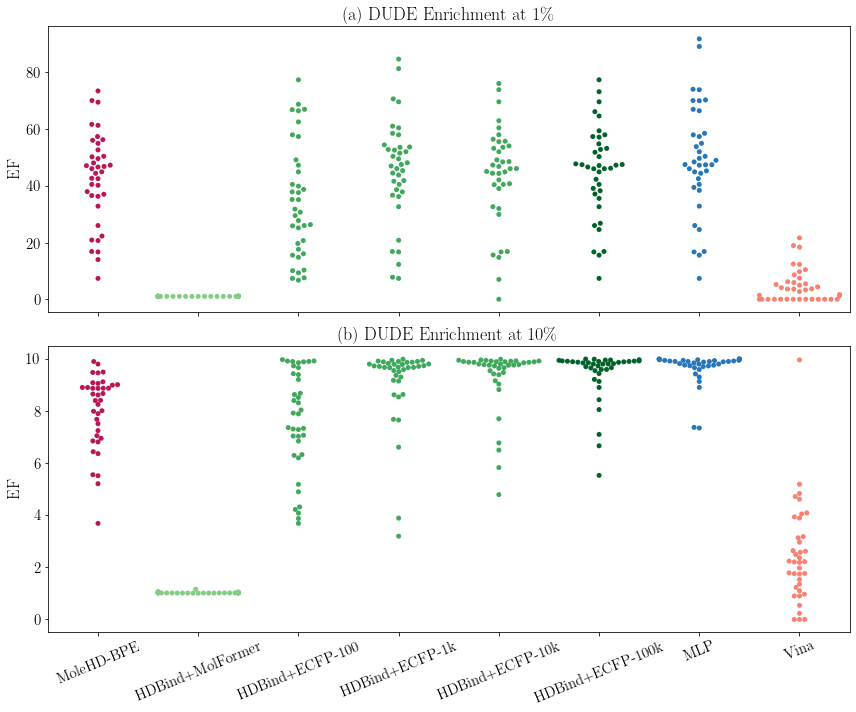

In [17]:
make_box_plot(enrich_1_df=grp_df[grp_df["p"] == .01], 
          enrich_10_df=grp_df[grp_df["p"] == .1],
             dataset="DUDE")

- should add the average EF (median?) to the labels on the horizontal axis
- scale the point size by standard deviation?
- standard scale the molformer embeddings?

In [18]:
def timing_plot(input_tup_list:list, dataset:str):
    
    
    f, ax = plt.subplots(1, 1, figsize=(12,10))
    
    df_dict = {"target": [], "model": [], "time": [], "format_name": []}
    for model_name, format_name in input_tup_list:
        
        data_path_list = list(data_p.glob(f"{model_name}.{dataset}*.pkl"))
        
        for path in data_path_list:
            with open(path, "rb") as handle:
                data = pickle.load(handle)
                
                test_time_list = []
                for i in range(10):
                    df_dict["time"].append(data["trials"][i]["test_time"]/data["y_test"].shape[0])
                    df_dict["target"].append(path.name)
                    df_dict["model"].append(model_name)
                    df_dict["format_name"].append(format_name)
                    

    df = pd.DataFrame(df_dict)
    xlabels = (df.groupby(["model", "format_name"]).median().reset_index()["format_name"]).values.tolist()
#     import pdb
#     pdb.set_trace()
    sns.swarmplot(data=df.groupby(["target", "model", "format_name"]).median().reset_index(),
                  order=[x for x in model_dict.keys()],
                  x="model", y="time", ax=ax)

    ax.tick_params(axis="x", labelrotation=22.5)
    ax.set_yscale("log")
#     labels = [item.get_text() for item in ax.get_xticklabels()]
#     labels = [x[1] for x in input_tup_list]
    ax.set_xticklabels(xlabels)
    
    f.savefig("lit-pcba-timing.png", dpi=600, bbox_inches="tight")
    
    return df
    

ValueError: The number of FixedLocator locations (8), usually from a call to set_ticks, does not match the number of ticklabels (6).

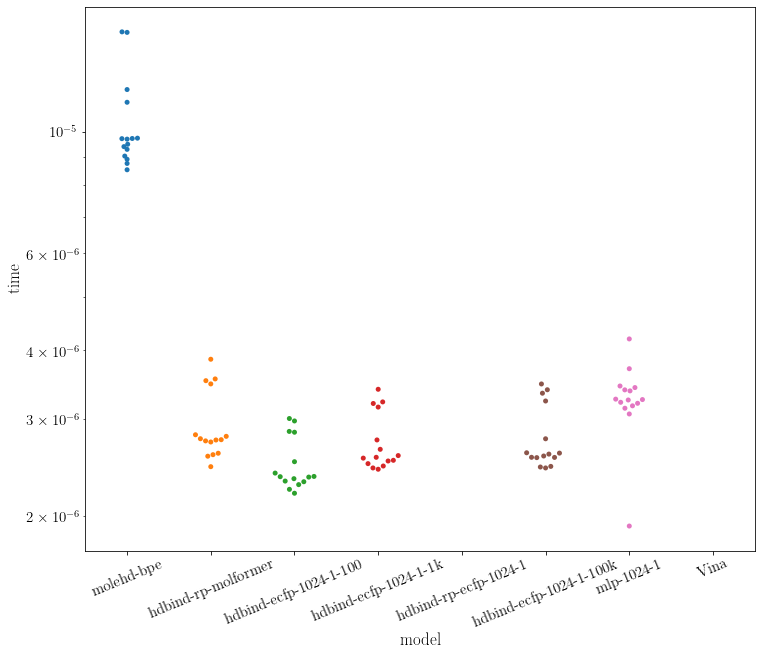

In [19]:
time_df = timing_plot([("mlp-1024-1", "MLP (GPU)"),
            ("hdbind-rp-molformer", "RP-MolFormer (GPU)"),
            ("molehd-bpe", "MoleHD-BPE (CPU)"),
            ("hdbind-ecfp-1024-1-100", "RP-ECFP-100 (GPU)"),
                      ("hdbind-ecfp-1024-1-1k", "RP-ECFP-1k (GPU)"),
                      ("hdbind-ecfp-1024-1-100k", "RP-ECFP-100k (GPU)")], 
                      dataset="lit-pcba")

In [ ]:
avg_times = time_df.groupby(["model"]).mean()["time"].reset_index()
# avg_times.reset_index()

In [ ]:
avg_times["time"][0], avg_times["model"][0]

In [ ]:
avg_times["time"][1], avg_times["model"][1]

In [ ]:
avg_times["time"][2], avg_times["model"][2]

In [ ]:
avg_times["time"][3], avg_times["model"][3]

In [ ]:
avg_times["time"][4], avg_times["model"][4]

In [ ]:
avg_times["time"][5], avg_times["model"][5]

---

In [ ]:
100 * abs( avg_times["time"][0] - avg_times["time"][4])/(avg_times["time"][4])

In [ ]:
avg_times["time"][4] / avg_times["time"][0]

In [ ]:
avg_times["time"][5] / avg_times["time"][0]

In [ ]:
avg_times["time"][0] / avg_times["time"][1]

- theres way more parameters in the hdbind-rp-molformer as compared to the mlp
- (1024 * 10000 = 10.24M parameters)
- (
- can D go higher? a .85x slow down from 100 to 10000 seems pretty small, there also seems to be a considerable increase in accuracy when pushing D higher...